In [45]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import cv2
import os
import random
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [46]:
# 데이터 로드
with open('image_data.pkl', 'rb') as f:
    image_data = pickle.load(f)

with open('target_data.pkl', 'rb') as f:
    target_data = pickle.load(f)

In [47]:
from collections import Counter

values_list = list(target_data.values())
value_counts = Counter(values_list)

for value, count in value_counts.items():
    print(f"Value: {value}, Count: {count}")

Value: 1, Count: 1110
Value: 0, Count: 540
Value: 2, Count: 312
Value: 3, Count: 270
Value: 5, Count: 168
Value: 4, Count: 93
Value: 6, Count: 81


### 0과 2,3을 묶어서 모델링

In [48]:
def merge_classes(target_data):
    binary_target_data = {}
    for key, value in target_data.items():
        if value in [2, 3]:
            binary_target_data[key] = '10'
        else:
            binary_target_data[key] = value
    
    return binary_target_data

binary_target_data = merge_classes(target_data)

In [49]:
filtered_target_data = {key: value for key, value in binary_target_data.items() if value in [0, '10']}


values_list = list(filtered_target_data.values())
value_counts = Counter(values_list)

for value, count in value_counts.items():
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 540
Value: 10, Count: 582


In [50]:
common_keys = set(image_data.keys()) & set(filtered_target_data.keys())

# 데이터 정렬
filtered_image_data = {key: image_data[key] for key in common_keys}
filtered_target_data = {key: filtered_target_data[key] for key in common_keys}

# X와 y 생성
X = np.array(list(filtered_image_data.values()))
y = np.array(list(filtered_target_data.values()))

print(f"Length of X: {len(X)}, Length of y: {len(y)}")

Length of X: 1122, Length of y: 1122


In [51]:
class_mapping = {'0': 0, '10': 1}
y = np.array([class_mapping[label] for label in y])
X = X / 255.0

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (897, 128, 128, 3), y_train shape: (897,)
X_test shape: (225, 128, 128, 3), y_test shape: (225,)


In [53]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 출력층
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)      

In [54]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [56]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight = class_weights,
    callbacks=[early_stopping]
)

Epoch 1/100
23/23 [==============================] - 5s 224ms/step - loss: 0.6988 - accuracy: 0.4672 - val_loss: 0.6908 - val_accuracy: 0.5278
Epoch 2/100
23/23 [==============================] - 5s 201ms/step - loss: 0.6926 - accuracy: 0.5230 - val_loss: 0.6907 - val_accuracy: 0.6500
Epoch 3/100
23/23 [==============================] - 5s 202ms/step - loss: 0.6922 - accuracy: 0.5286 - val_loss: 0.6862 - val_accuracy: 0.6111
Epoch 4/100
23/23 [==============================] - 5s 198ms/step - loss: 0.6873 - accuracy: 0.5593 - val_loss: 0.6814 - val_accuracy: 0.6167
Epoch 5/100
23/23 [==============================] - 5s 199ms/step - loss: 0.6860 - accuracy: 0.5537 - val_loss: 0.6746 - val_accuracy: 0.6389
Epoch 6/100
23/23 [==============================] - 5s 202ms/step - loss: 0.6832 - accuracy: 0.5384 - val_loss: 0.6668 - val_accuracy: 0.5833
Epoch 7/100
23/23 [==============================] - 5s 199ms/step - loss: 0.6736 - accuracy: 0.5941 - val_loss: 0.6583 - val_accuracy: 0.5778

In [57]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 - 0s - loss: 0.4896 - accuracy: 0.8089 - 349ms/epoch - 44ms/step
Test Loss: 0.48964911699295044
Test Accuracy: 0.8088889122009277


### 사전학습모델 사용 (EfficientNetB0)

In [40]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, 
                            input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))
base_model.trainable = False

In [41]:
# 모델 설계
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [42]:
# 데이터 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = np.where(y_train > 0, 1, 0)
y_test = np.where(y_test > 0, 1, 0)

In [ ]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    # class_weight = class_weights
    # callbacks=[lr_scheduler]
)

Epoch 1/20
29/29 [==============================] - 14s 273ms/step - loss: 0.7268 - accuracy: 0.4771 - val_loss: 0.6955 - val_accuracy: 0.5067
Epoch 2/20
29/29 [==============================] - 7s 234ms/step - loss: 0.7025 - accuracy: 0.5006 - val_loss: 0.7027 - val_accuracy: 0.4933
Epoch 3/20
29/29 [==============================] - 7s 227ms/step - loss: 0.7009 - accuracy: 0.5195 - val_loss: 0.6994 - val_accuracy: 0.4933
Epoch 4/20
29/29 [==============================] - 6s 222ms/step - loss: 0.7007 - accuracy: 0.5128 - val_loss: 0.6958 - val_accuracy: 0.4933
Epoch 5/20
29/29 [==============================] - 6s 224ms/step - loss: 0.6955 - accuracy: 0.5173 - val_loss: 0.6933 - val_accuracy: 0.4933
Epoch 6/20
29/29 [==============================] - 6s 225ms/step - loss: 0.6973 - accuracy: 0.4883 - val_loss: 0.6940 - val_accuracy: 0.4933
Epoch 7/20
29/29 [==============================] - 7s 230ms/step - loss: 0.6912 - accuracy: 0.5262 - val_loss: 0.6946 - val_accuracy: 0.4933
Epoch

KeyboardInterrupt: 

In [39]:
# 모델 훈련 설계

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# 모델 훈련

fit_history = model.fit(datasets[0],
                        steps_per_epoch=60,
                        epochs=20,
                        validation_data=datasets[2],
                        validation_steps=30)

In [6]:
# value_1_indices = np.where(y == 1)[0]
# print(f"Indices for class 1: {value_1_indices}")
# print(f"Number of samples for class 1: {len(value_1_indices)}")

In [15]:
# 1번 value의 인덱스만 선택
value_1_indices = np.where(y == '1')[0]

# 다른 클래스의 인덱스 선택
other_indices = np.where(y != '1')[0]

# 1번 value를 일정 개수로 줄이기 (예: 500개로 제한)
np.random.seed(42)  # 재현성을 위해 설정
reduced_value_1_indices = np.random.choice(value_1_indices, size=500, replace=False)

# 줄어든 데이터와 다른 클래스 데이터를 합침
final_indices = np.concatenate([reduced_value_1_indices, other_indices])

# 새로운 X, y 데이터 생성
X_balanced = X[final_indices]
y_balanced = y[final_indices]

# 데이터 분포 확인
print("New target distribution:", Counter(y_balanced))


New target distribution: Counter({'0': 540, '1': 500, 'other': 342, '2': 312, '3': 270})


In [17]:
class_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, 'other': 4}
y_new_balanced = np.array([class_mapping[label] for label in y_balanced])
X_balanced = X_balanced/ 255.0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_new_balanced, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1571, 128, 128, 3), y_train shape: (1571,)
X_test shape: (393, 128, 128, 3), y_test shape: (393,)


In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 출력층
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)       0

In [21]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


In [34]:
X = np.array(list(image_data.values()))
y = np.array(list(merged_target_data.values()))

X = X / 255.0

unique_classes = np.unique(y)
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

In [35]:
# 원-핫 인코딩
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2059, 128, 128, 3), y_train shape: (2059, 5)
X_test shape: (515, 128, 128, 3), y_test shape: (515, 5)


In [37]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print(f"After squeeze - y_train shape: {y_train.shape}")
print(f"After squeeze - y_test shape: {y_test.shape}")

After squeeze - y_train shape: (2059, 5)
After squeeze - y_test shape: (515, 5)


In [38]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # 출력층
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

In [39]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20


65/65 [==============================] - 15s 213ms/step - loss: 1.4939 - accuracy: 0.4293 - val_loss: 1.4967 - val_accuracy: 0.4019
Epoch 2/20
65/65 [==============================] - 14s 210ms/step - loss: 1.4638 - accuracy: 0.4390 - val_loss: 1.5082 - val_accuracy: 0.4019
Epoch 3/20
65/65 [==============================] - 14s 214ms/step - loss: 1.4634 - accuracy: 0.4386 - val_loss: 1.4824 - val_accuracy: 0.4019
Epoch 4/20
65/65 [==============================] - 13s 199ms/step - loss: 1.4637 - accuracy: 0.4376 - val_loss: 1.4865 - val_accuracy: 0.4019
Epoch 5/20
65/65 [==============================] - 13s 200ms/step - loss: 1.4576 - accuracy: 0.4390 - val_loss: 1.4756 - val_accuracy: 0.4019
Epoch 6/20
65/65 [==============================] - 13s 201ms/step - loss: 1.4593 - accuracy: 0.4390 - val_loss: 1.4847 - val_accuracy: 0.4019
Epoch 7/20
65/65 [==============================] - 13s 201ms/step - loss: 1.4546 - accuracy: 0.4390 - val_loss: 1.4827 - val_accuracy: 0.40

In [12]:
class_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 'other': 4}
y = np.array([class_mapping[label] for label in y])

KeyError: 1110

In [102]:
X = np.random.rand(1216, 64, 64, 3)
y = np.random.choice(['0', '1', '2', '3', 'other'], size=1216)

# 클래스 매핑 (문자열로 키 설정)
class_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, 'other': 4}
y = np.array([class_mapping[label] for label in y])

In [103]:
y = to_categorical(y, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 모델 생성
model = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5개의 출력 클래스
])


In [107]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # 다중 클래스 분류 손실 함수
    metrics=['accuracy']  # 평가 지표
)


In [108]:
history = model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
31/31 [==============================] - 3s 56ms/step - loss: 1.6087 - accuracy: 0.2006 - val_loss: 1.6114 - val_accuracy: 0.1639
Epoch 2/20
31/31 [==============================] - 2s 53ms/step - loss: 1.6075 - accuracy: 0.2027 - val_loss: 1.6110 - val_accuracy: 0.1803
Epoch 3/20
31/31 [==============================] - 2s 53ms/step - loss: 1.6072 - accuracy: 0.2181 - val_loss: 1.6108 - val_accuracy: 0.2008
Epoch 4/20
31/31 [==============================] - 2s 53ms/step - loss: 1.6044 - accuracy: 0.2490 - val_loss: 1.6110 - val_accuracy: 0.2008
Epoch 5/20
31/31 [==============================] - 1s 46ms/step - loss: 1.6045 - accuracy: 0.2479 - val_loss: 1.6110 - val_accuracy: 0.1926
Epoch 6/20
31/31 [==============================] - 1s 46ms/step - loss: 1.6028 - accuracy: 0.2387 - val_loss: 1.6110 - val_accuracy: 0.2172
Epoch 7/20
31/31 [==============================] - 1s 47ms/step - loss: 1.6025 - accuracy: 0.2335 - val_loss: 1.6113 - val_accuracy: 0.1803
Epoch 8/20
31

In [41]:
# 타겟 데이터와 이미지 데이터를 분리
X = np.array(list(image_data.values()))
y = np.array(list(merged_target_data.values()))

# 1번 value의 인덱스만 선택
value_1_indices = np.where(y == 1)[0]

# 다른 클래스의 인덱스 선택
other_indices = np.where(y != 1)[0]

# 1번 value를 일정 개수로 줄이기 (예: 500개로 제한)
np.random.seed(42)  # 재현성을 위해 설정
reduced_value_1_indices = np.random.choice(value_1_indices, size=500, replace=False)

# 줄어든 데이터와 다른 클래스 데이터를 합침
final_indices = np.concatenate([reduced_value_1_indices, other_indices])

# 새로운 X, y 데이터 생성
X_balanced = X[final_indices]
y_balanced = y[final_indices]

# 데이터 분포 확인
print("New target distribution:", Counter(y_balanced))

ValueError: 'a' cannot be empty unless no samples are taken

In [96]:
augmentation_count = 10  # 증강 이미지 개수
target_classes = [4, 5, 6]  # 적은 클래스

for target_class in target_classes:
    image_paths = [f"data/{target_class}/{img}" for img in os.listdir(f"data/{target_class}")]
    augmented_images = augment_class_data(image_paths, target_class, augmentation_count)
    
    # 증강된 이미지 저장
    save_dir = f"augmented_data/{target_class}"
    os.makedirs(save_dir, exist_ok=True)
    for i, aug_img in enumerate(augmented_images):
        save_path = os.path.join(save_dir, f"augmented_{i}.jpg")
        cv2.imwrite(save_path, aug_img)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/4'

In [75]:
# 데이터를 배열로 변환
X = np.array(list(image_data.values()))  # 이미지 데이터
y = np.array(list(target_data.values()))  # 타겟 데이터

# 데이터 정규화
X = X / 255.0

# 타겟 데이터의 고유 클래스
num_classes = len(np.unique(y))

In [33]:
valid_classes = [1, 2, 3]
indices = [i for i, label in enumerate(y) if label in valid_classes]

X_filtered = X[indices]
y_filtered = y[indices]

In [34]:
class_map = {1: 0, 2: 1, 3: 2}  # 클래스 1, 2, 3을 0, 1, 2로 매핑
y_filtered = np.array([class_map[label] for label in y_filtered])

In [41]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [36]:
num_classes = len(valid_classes)
y_filtered = to_categorical(y_filtered, num_classes=num_classes)

# 입력 크기 (224*224)
X_filtered_resized = np.array([cv2.resize(img, (224, 224)) for img in X_filtered])
X_filtered_preprocessed = preprocess_input(X_filtered_resized)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered_preprocessed, y_filtered, test_size=0.2, random_state=42
)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (654, 224, 224, 3)
y_train shape: (654, 3)


In [69]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Dermato


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [70]:
# 모델 설계
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_33 (Dense)            (None, 128)               163968    
                                                                 
 dense_34 (Dense)            (None, 3)                 387       
                                                                 
Total params: 4213926 (16.07 MB)
Trainable params: 3452059 (13.17 MB)
Non-trainable params: 761867 (2.91 MB)
_________________________________________________________________


In [71]:
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
# )


# 학습 진행
history = model.fit(
    X_train, y_train,
    # validation_data = (X_test, y_test),
    epochs=20,
    batch_size=32,
    # class_weights = class_weights,
    validation_split=0.2,
    # callbacks=[lr_scheduler]
)

Epoch 1/20
17/17 [==============================] - 31s 1s/step - loss: 1.1937 - accuracy: 0.2447 - val_loss: 1.3057 - val_accuracy: 0.1374
Epoch 2/20
17/17 [==============================] - 17s 1s/step - loss: 1.0659 - accuracy: 0.4914 - val_loss: 1.3067 - val_accuracy: 0.1374
Epoch 3/20
17/17 [==============================] - 17s 997ms/step - loss: 1.0082 - accuracy: 0.5449 - val_loss: 1.2901 - val_accuracy: 0.1374
Epoch 4/20
17/17 [==============================] - 17s 1s/step - loss: 0.9564 - accuracy: 0.6176 - val_loss: 1.2765 - val_accuracy: 0.1374
Epoch 5/20
17/17 [==============================] - 19s 1s/step - loss: 0.9374 - accuracy: 0.6252 - val_loss: 1.2484 - val_accuracy: 0.1374
Epoch 6/20
17/17 [==============================] - 20s 1s/step - loss: 0.9081 - accuracy: 0.6444 - val_loss: 1.2296 - val_accuracy: 0.1374
Epoch 7/20
17/17 [==============================] - 19s 1s/step - loss: 0.9161 - accuracy: 0.6405 - val_loss: 1.2157 - val_accuracy: 0.1374
Epoch 8/20
 4/17 

KeyboardInterrupt: 

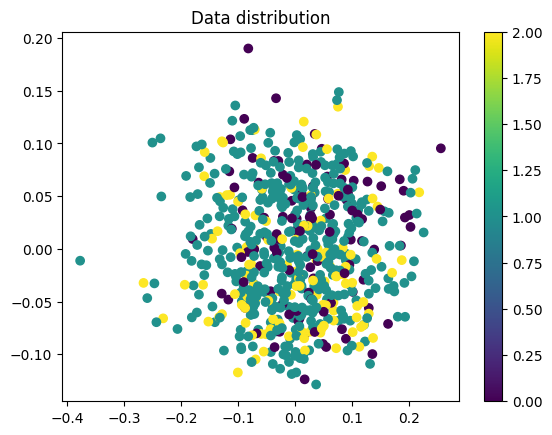

In [73]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 데이터 차원 축소 및 시각화
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.argmax(y_train, axis=1))
plt.colorbar()
plt.title("Data distribution")
plt.show()